In [1]:
import harmony
import palantir

# Plotting and miscellaneous imports
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Initialize random seed
import random
random.seed(101)

%matplotlib inline

In [3]:
harmony_dir = '/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/harmony/data/'

csv_files = [harmony_dir + '180831_T1_raw-data_2890cells.csv',
            harmony_dir + '180831_T2_raw-data_5211cells.csv',
            harmony_dir + '180831_T3_raw-data_5474cells.csv',
            harmony_dir + '180831_T4_raw-data_3714cells.csv',
            harmony_dir + '180831_T5_raw-data_6139cells.csv']
sample_names = ['T1', 'T2', 'T3', 'T4', 'T5']

counts = harmony.utils.load_from_csvs(csv_files, sample_names)

Loading count matrices...
T1
T2
T3
T4
T5
Concatenating data..


In [4]:
norm_df = harmony.utils.normalize_counts(counts)

In [5]:
hvg_genes = harmony.utils.hvg_genes(norm_df)

In [8]:
len(hvg_genes)
hvg_genes

Index(['MT1G', 'REN', 'FABP4', 'MT2A', 'MT1X', 'MTRNR2L1', 'IGF2', 'CFD',
       'NPPB', 'MT1A',
       ...
       'CYP26A1', 'COLCA2', 'RP11-572C15.6', 'TRIB1', 'ARHGAP12', 'SETBP1',
       'PROCR', 'PID1', 'RP1-251M9.2', 'NGF'],
      dtype='object', length=1000)

From the tutorial: "Data can be optionally log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale."
Therefore, keep both the normalized and log normalized data. 

In [10]:
data_df_log = harmony.utils.log_transform(norm_df.loc[:,hvg_genes])
data_df = norm_df

<h3>Metadata</h3>

In [32]:
metadata = pd.read_csv('/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/harmony/data/180831_metadata_23428cells.csv', index_col=0)

In [43]:
index = list(map(lambda x: 'T' + x[-1] + '_' + x, metadata.index))
metadata.index = index

<h3>Harmony augmented affinity matrix</h3>

In [13]:
timepoints = ['T1', 'T2', 'T3', 'T4', 'T5']
tp = pd.Series(index=data_df.index)
for t in timepoints:
    cells = data_df.index[data_df.index.str.contains(t)]
    tp[cells] = t

In [14]:
timepoint_connections = pd.DataFrame(columns=[0, 1])
index = 0
for i in range(len(timepoints)-1):
    timepoint_connections.loc[index, :] = timepoints[i:i+2]; index += 1
timepoint_connections

,0,1
0,T1,T2
1,T2,T3
2,T3,T4
3,T4,T5


In [15]:
aug_aff, aff = harmony.core.augmented_affinity_matrix(data_df, tp, timepoint_connections)
aug_aff_log, aff_log = harmony.core.augmented_affinity_matrix(data_df_log, tp, timepoint_connections)

Running PCA with 22 components
Nearest neighbor computation...
Constucting affinities between T1 and T2...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between T2 and T3...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between T3 and T4...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between T4 and T5...
t+1 neighbors of t...
t neighbors of t+1...
Running PCA with 426 components
Nearest neighbor computation...
Constucting affinities between T1 and T2...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between T2 and T3...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between T3 and T4...
t+1 neighbors of t...
t neighbors of t+1...
Constucting affinities between T4 and T5...
t+1 neighbors of t...
t neighbors of t+1...


<h3>Visualization using force directed layouts</h3>

In [16]:
layout = harmony.plot.force_directed_layout(aug_aff, data_df.index)
layout_log = harmony.plot.force_directed_layout(aug_aff_log, data_df.index)

100%|██████████| 500/500 [02:58<00:00,  2.71it/s]


BarnesHut Approximation  took  62.85  seconds
Repulsion forces  took  100.95  seconds
Gravitational forces  took  0.47  seconds
Attraction forces  took  8.63  seconds
AdjustSpeedAndApplyForces step  took  2.61  seconds


100%|██████████| 500/500 [03:46<00:00,  2.02it/s]


BarnesHut Approximation  took  59.90  seconds
Repulsion forces  took  151.97  seconds
Gravitational forces  took  0.46  seconds
Attraction forces  took  8.57  seconds
AdjustSpeedAndApplyForces step  took  2.55  seconds


<b>Layout non log-transformed data</b>

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


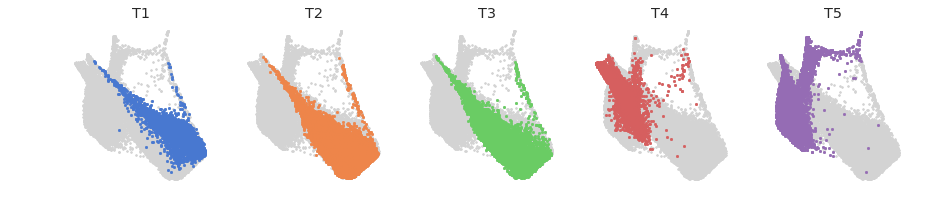

In [48]:
harmony.plot.plot_timepoints(layout, tp)

Monocle branches

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


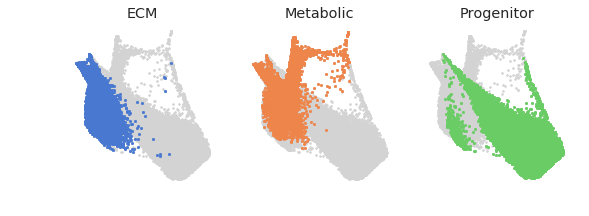

In [49]:
harmony.plot.plot_timepoints(layout, metadata['branch'])

<b>Palantir trajectory detection non log-transformed data</b>

The first step in Palantir trajectory detection is to project data onto diffusion maps. Harmony augmented affinity matrix is used as the input for identifying diffusion maps. 

In [76]:
dm_res = palantir.utils.run_diffusion_maps(aug_aff)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
ms_data.index = data_df.index

In [77]:
#Start cell was chosen on Monocle pseudotime == 0.
start_cell = 'T1_TCTGGAAAGTGCGATG-1'
pr_res = palantir.core.run_palantir(ms_data, start_cell, use_early_cell_as_start=False)

Sampling and flocking waypoints...
Time for determining waypoints: 0.04483475685119629 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.812998112042745 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir results. The second row shows the identified branches.

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


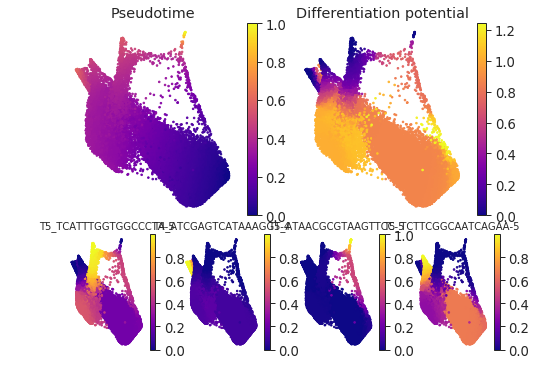

In [78]:
palantir.plot.plot_palantir_results(pr_res, layout)

tSNE layout. Palantir constructs the tSNE map in the embedded space since these maps better represent the differentiation trajectories.

In [149]:
tsne27 = palantir.utils.run_tsne(ms_data, random_state=27)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


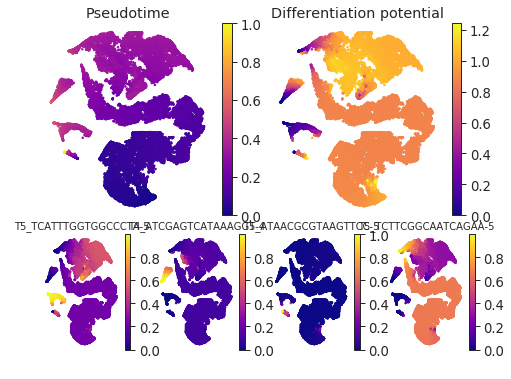

In [148]:
palantir.plot.plot_palantir_results(pr_res, tsne27)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


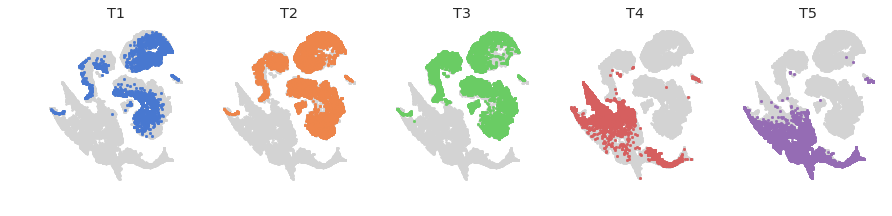

In [152]:
harmony.plot.plot_timepoints(tsne27, tp)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


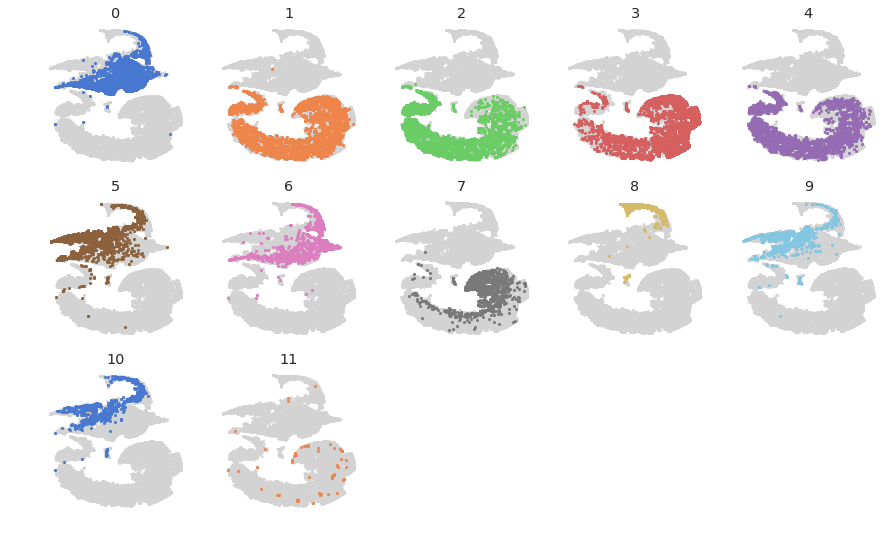

In [146]:
harmony.plot.plot_timepoints(tsne30, metadata['res.0.5'])

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


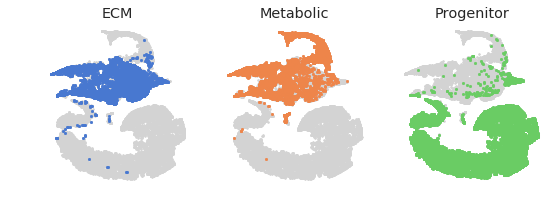

In [143]:
harmony.plot.plot_timepoints(tsne30, metadata['branch'])

Visualizing gene expression

In [ ]:
imp_df = palantir.utils.run_magic_imputation(data_df, dm_res)

Branch marker genes from Monocle analysis. First row are U branch markers, second row L branch markers. 

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


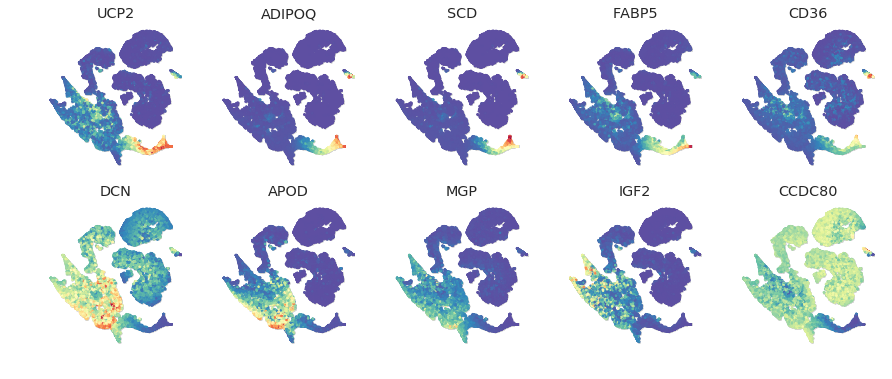

In [153]:
palantir.plot.plot_gene_expression(imp_df, tsne27, ['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36', 'DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


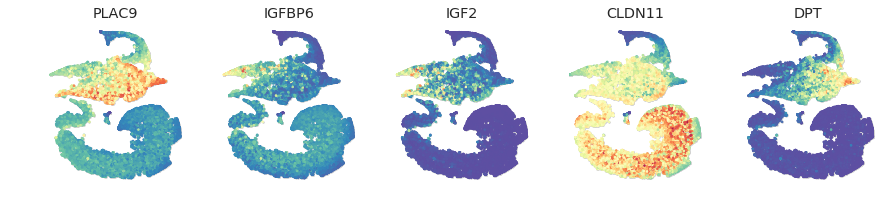

In [147]:
palantir.plot.plot_gene_expression(imp_df, tsne30, ['PLAC9', 'IGFBP6', 'IGF2', 'CLDN11', 'DPT'])


/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


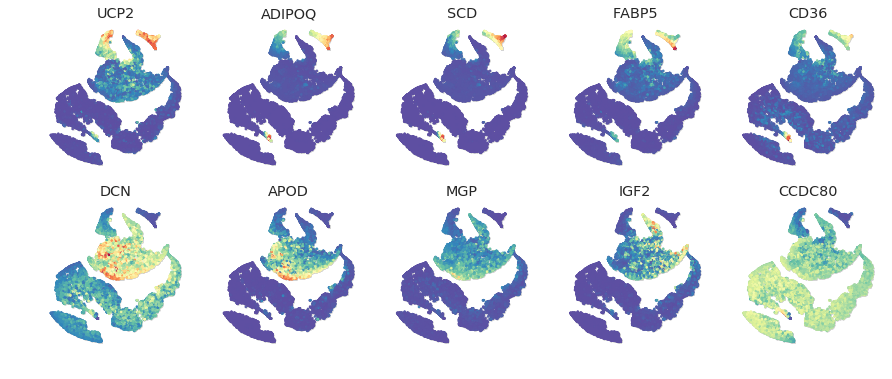

In [103]:
palantir.plot.plot_gene_expression(imp_df, tsne, ['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36', 'DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

<b>Layout log transformed data</b>

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


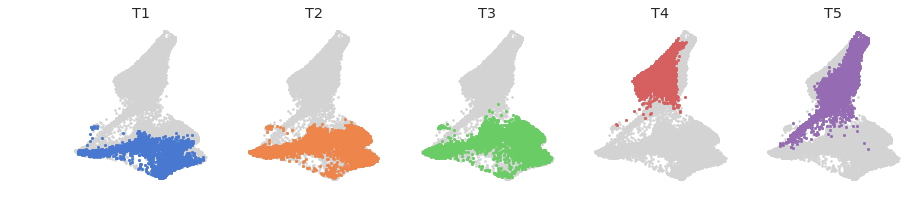

In [50]:
harmony.plot.plot_timepoints(layout_log, tp)

Monocle branches

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


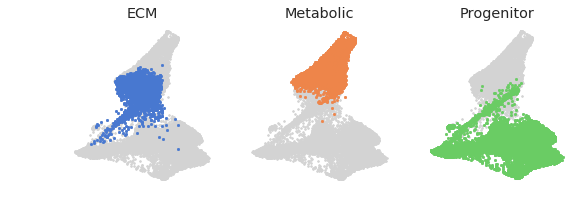

In [51]:
harmony.plot.plot_timepoints(layout_log, metadata['branch'])

<b>Palantir trajectory detection log transformed data</b>

In [60]:
dm_res_log = palantir.utils.run_diffusion_maps(aug_aff_log)
ms_data_log = palantir.utils.determine_multiscale_space(dm_res_log)
ms_data_log.index = data_df_log.index

In [62]:
#Start cell was chosen on Monocle pseudotime == 0.
start_cell = 'T1_TCTGGAAAGTGCGATG-1'
pr_res_log = palantir.core.run_palantir(ms_data_log, start_cell, use_early_cell_as_start=False)

Sampling and flocking waypoints...
Time for determining waypoints: 0.04305113951365153 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.9028798182805379 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9996
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


Palantir results. The second row shows the identified branches.

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


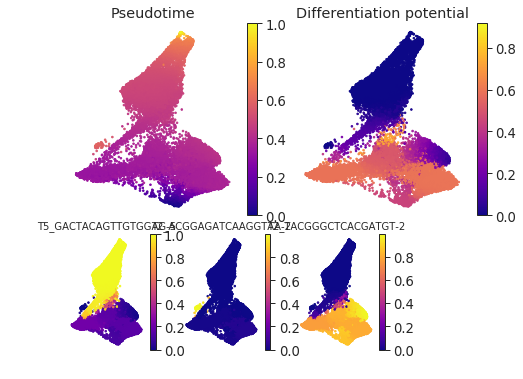

In [64]:
palantir.plot.plot_palantir_results(pr_res_log, layout_log)

tSNE layout. Palantir constructs the tSNE map in the embedded space since these maps better represent the differentiation trajectories.

In [156]:
tsne_log_12 = palantir.utils.run_tsne(ms_data_log, random_state=12)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


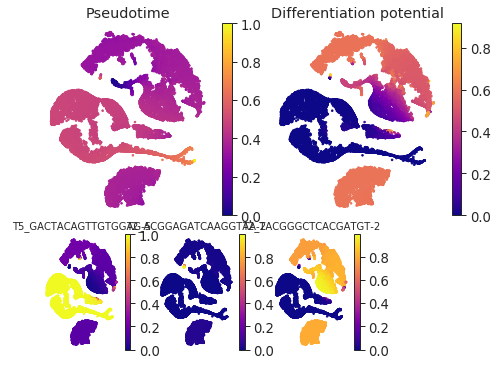

In [157]:
palantir.plot.plot_palantir_results(pr_res_log, tsne_log_12)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


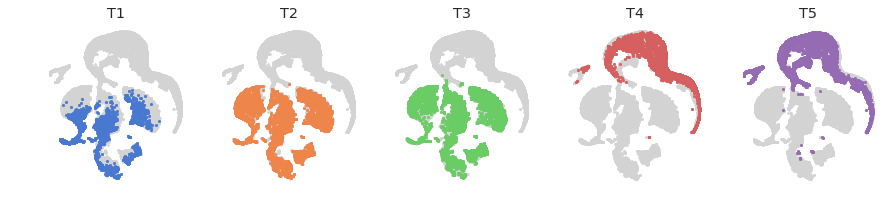

In [83]:
harmony.plot.plot_timepoints(tsne_log, tp)

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


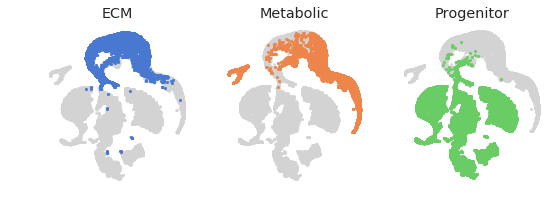

In [88]:
harmony.plot.plot_timepoints(tsne_log, metadata['branch'])

Visualizing gene expression

In [89]:
imp_df_log = palantir.utils.run_magic_imputation(data_df_log, dm_res_log)

Branch marker genes from Monocle analysis. First row are U branch markers, second row L branch markers. 

/tools/anaconda/3-4.4.0/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


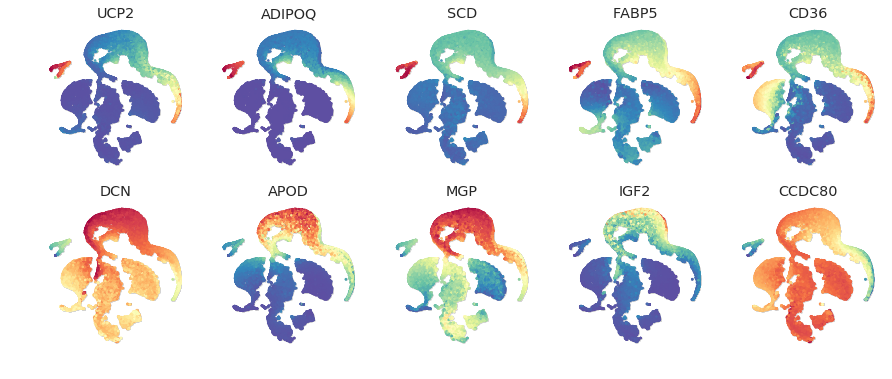

In [92]:
palantir.plot.plot_gene_expression(imp_df_log, tsne_log, ['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36', 'DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

<h3>Gene expression trends</h3>

In [ ]:
def run_tsne(data, n_dim=2, perplexity=150, **kwargs):
    """Run tSNE
    :param data: Dataframe of cells X genes. Typicaly multiscale space diffusion components
    :param n_dim: Number of dimensions for tSNE embedding
    :return: tSNE embedding of the data
    """
    tsne = TSNE(n_components=n_dim, perplexity=perplexity,
                **kwargs).fit_transform(data.values)
    tsne = pd.DataFrame(tsne, index=data.index)
    tsne.columns = ['x', 'y']
    return tsne